# Vollständige First-Level Analyse + Region of Interest Analyse

### module importieren

In [1]:
import glob

import numpy as np
import pandas as pd
from sklearn import preprocessing

from nilearn import plotting, image, input_data
from nistats import first_level_model, reporting, regression

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('talk')

/opt/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/opt/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/opt/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/opt/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


### Strukturelles Bild

In [2]:
mpr_img = '../data/sub-01_T1w_space-MNI152NLin2009cAsym_preproc.nii.gz'

### fMRT-Daten

In [3]:
fmri_img_list = glob.glob('../data/sub-01_task-imagery_run-0*_bold_space-MNI152NLin2009cAsym_preproc.nii.gz')
fmri_img_list.sort()
fmri_img_list = fmri_img_list[1:]
fmri_img_list

['../data/sub-01_task-imagery_run-01_bold_space-MNI152NLin2009cAsym_preproc.nii.gz',
 '../data/sub-01_task-imagery_run-02_bold_space-MNI152NLin2009cAsym_preproc.nii.gz',
 '../data/sub-01_task-imagery_run-03_bold_space-MNI152NLin2009cAsym_preproc.nii.gz',
 '../data/sub-01_task-imagery_run-04_bold_space-MNI152NLin2009cAsym_preproc.nii.gz']

alle runs hintereinanderhängen

In [4]:
fmri_imgs = image.concat_imgs(fmri_img_list)

wie viele Volumen sind in einem run?

In [5]:
n_volumes = image.load_img(fmri_img_list[-1]).shape[-1]
n_volumes

203

wie viele Volumen sind in der zusammengeführten Zeitserie?

In [6]:
fmri_imgs.shape

(65, 77, 40, 812)

### Das Design

In [7]:
onset_csvs = glob.glob('../data/sub-01_task-imagery_run-0*_events.tsv')
onset_csvs.sort()
onset_csvs = onset_csvs[1:]
onset_csvs

['../data/sub-01_task-imagery_run-01_events.tsv',
 '../data/sub-01_task-imagery_run-02_events.tsv',
 '../data/sub-01_task-imagery_run-03_events.tsv',
 '../data/sub-01_task-imagery_run-04_events.tsv']

die zu analysierende Bedingung auswählen (trial_type)

In [8]:
def make_onsets(csv_file):
    df = pd.read_csv(csv_file,sep='\t')
    df.loc[:,'trial_num'] = [('0%s'%x)[-2:] for x in df.index.get_values().astype(str)]
    df.loc[:,'trial_type'] = df.loc[:,'trial_domain']
    #df.loc[:,'trial_type'] = df.loc[:,'trial_subdomain']

    return df

In [9]:
onset_df = make_onsets(onset_csvs[-1])
onset_df.tail()

,onset,duration,trial_domain,trial_subdomain,trial_content,trial_num,trial_type
15,450,30,EMOTION,Negativ,Waldbrand,15,EMOTION
16,480,30,GESICHTER,Bekannt,Kommilitonen,16,GESICHTER
17,510,30,MOTORIK,Haende,Boxen,17,MOTORIK
18,540,30,SPRACHE,Sprechen,Lebensmittel,18,SPRACHE
19,570,30,RUHE,Ruhe,Ruhe,19,RUHE


### Aus den Onsets das Design erstellen

Meta-Informationen zu den runs

In [10]:
my_tr = 3
my_duration = n_volumes*my_tr
my_duration # dauer eines runs in sekunden (volumes x tr)

609

Onsets mit HRF verbinden

In [11]:
def make_design(df,my_tr=my_tr,my_duration=my_duration):
    frame_times = np.arange(0,my_duration,my_tr)
    design_matrix = first_level_model.make_first_level_design_matrix(frame_times=frame_times,
                                                                     events=df,
                                                                     #drift_model=None
                                                                     period_cut=300,
                                                                    )
    return design_matrix

Beispiel:

/opt/miniconda3/lib/python3.7/site-packages/nistats/hemodynamic_models.py:268: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  frame_times.max() * (1 + 1. / (n - 1)), n_hr)
/opt/miniconda3/lib/python3.7/site-packages/nistats/hemodynamic_models.py:55: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  time_stamps = np.linspace(0, time_length, float(time_length) / dt)


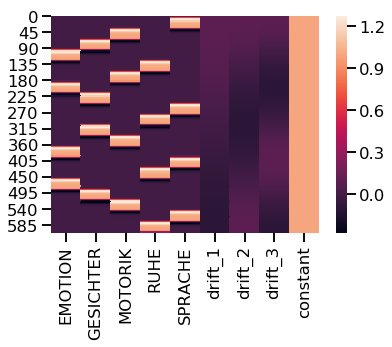

In [12]:
sns.heatmap(make_design(onset_df));

### Ein großes Design für alle 4 runs

In [13]:
def make_big_design(onset_csvs):
    
    design_matrix = pd.DataFrame()
    for run_num,onset_csv in enumerate(onset_csvs):
        this_onset = make_onsets(onset_csv)
        this_design = make_design(this_onset)
        this_design.index = this_design.index+my_duration*run_num
        this_design.columns = ['%s-run%s'%(c,run_num+1) for c in this_design.columns]

        design_matrix = pd.concat([design_matrix, this_design],sort=False)
        design_matrix = design_matrix.fillna(0)

    return design_matrix

In [14]:
design_matrix = make_big_design(onset_csvs)

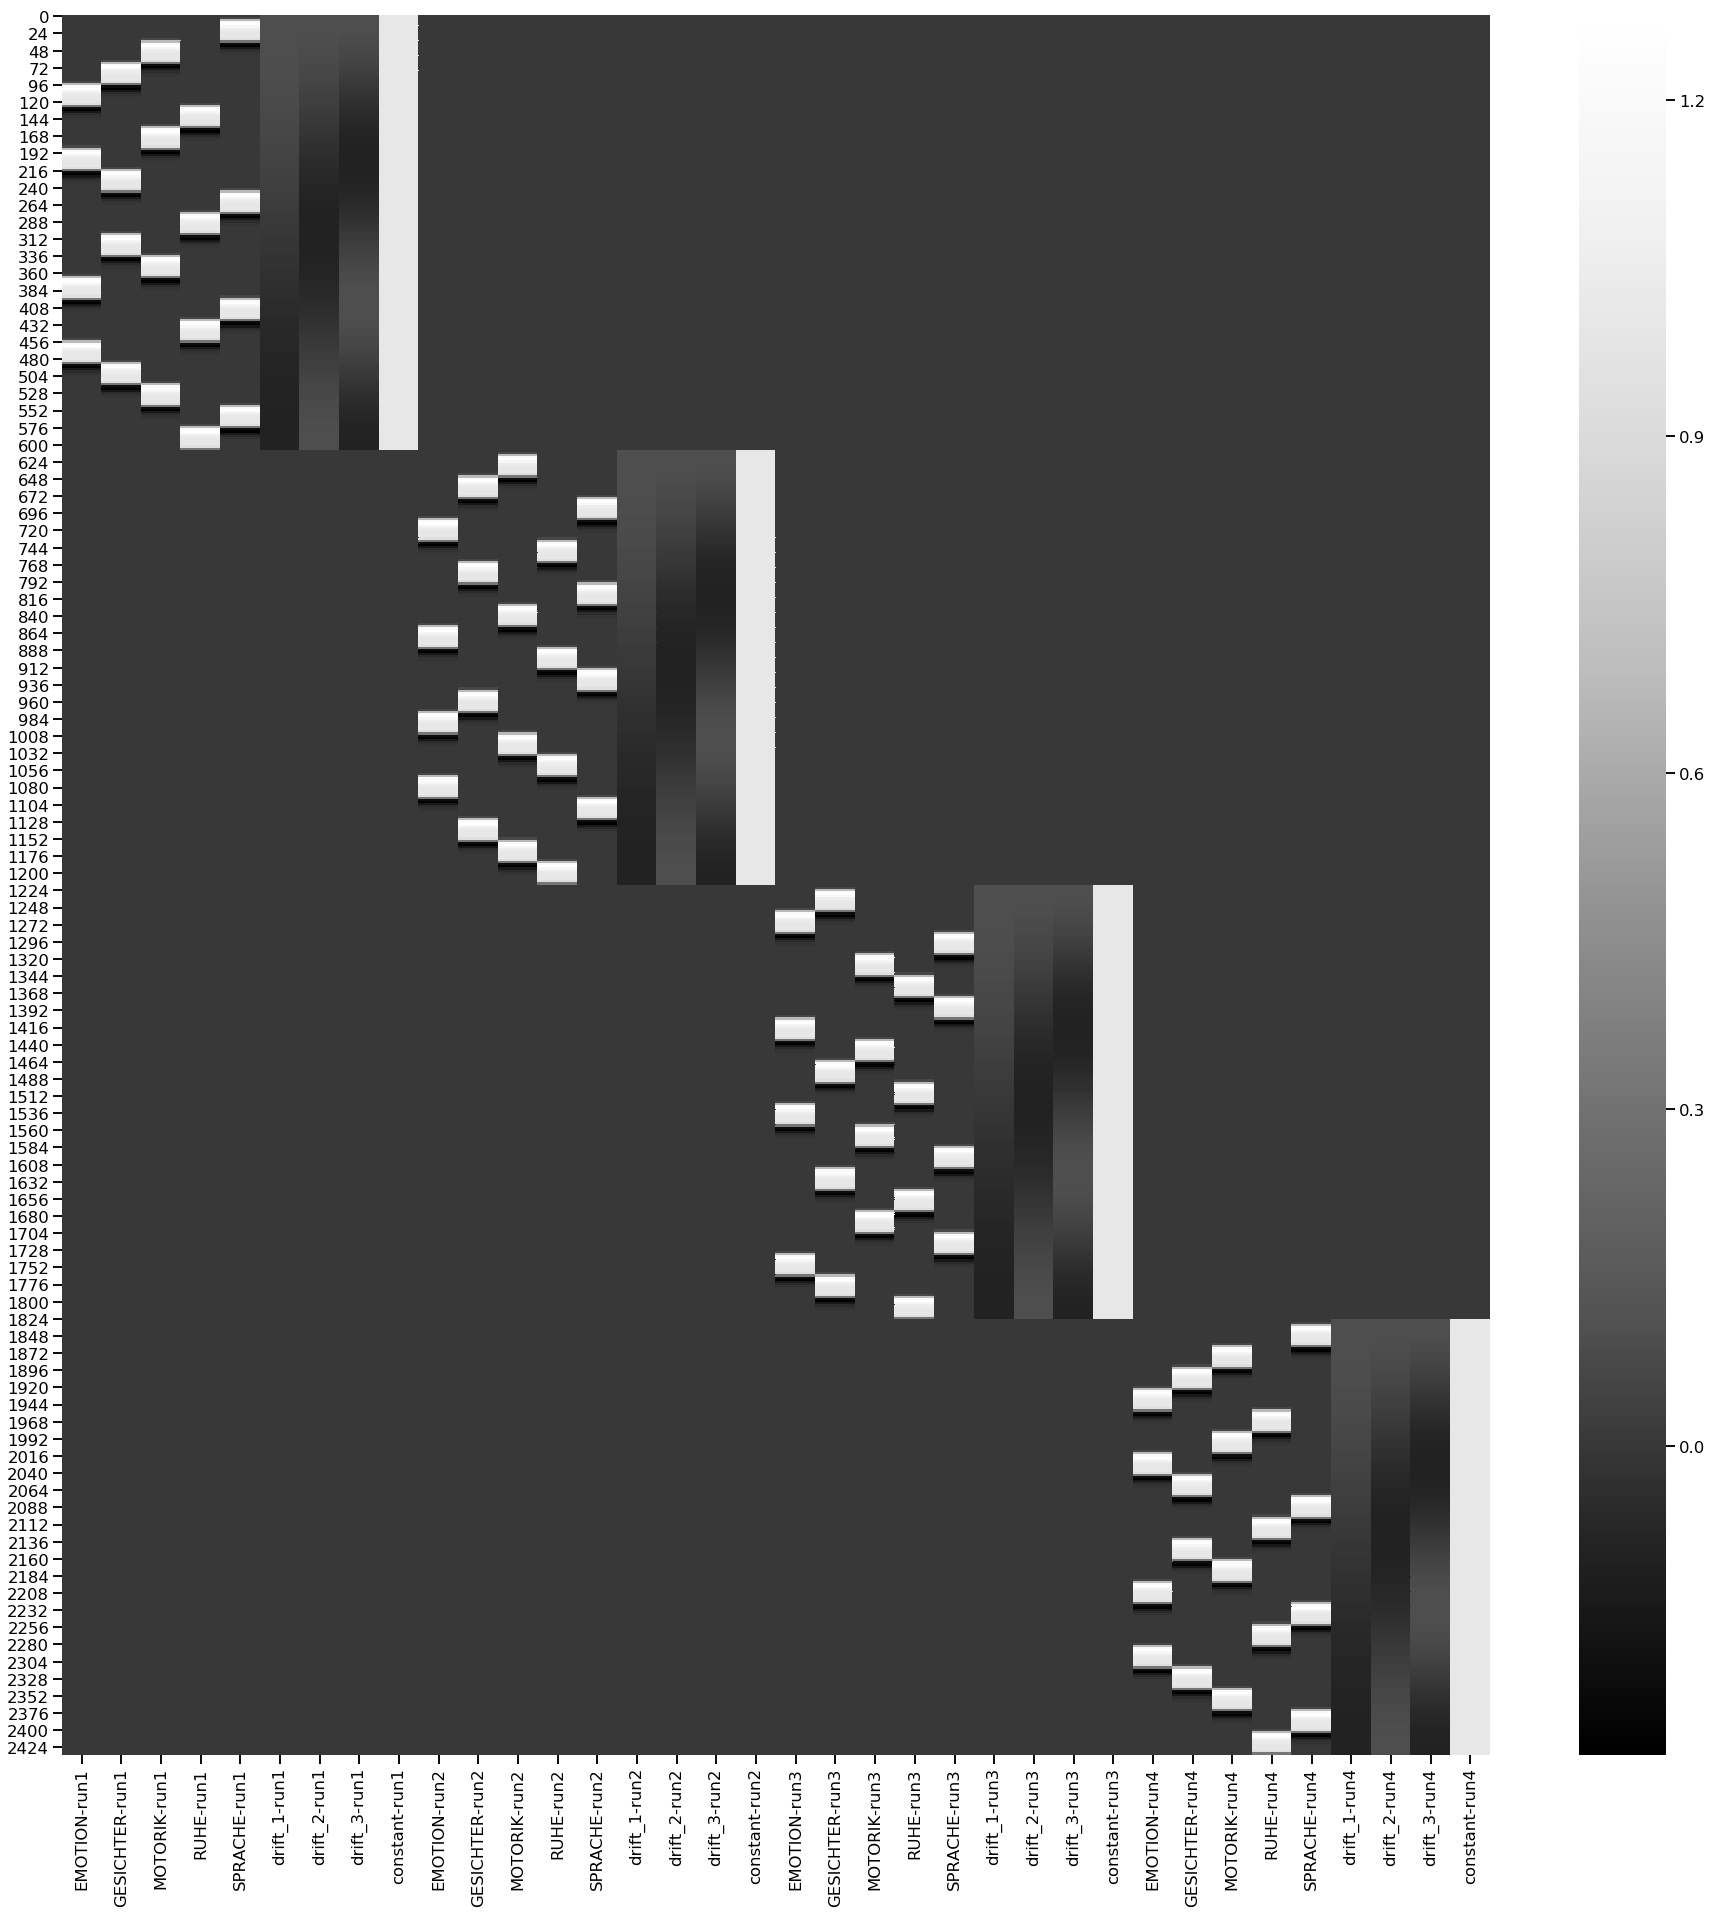

In [15]:
fig,ax = plt.subplots(1,1,figsize=(32,32))
sns.heatmap(design_matrix,ax=ax,cmap='Greys_r')
plt.show()

### Ein Modell welches Daten und Design verbindet

In [16]:
fmri_glm = first_level_model.FirstLevelModel(t_r=3,
                                             smoothing_fwhm=6, # hier auswählen,
                                            )

In [17]:
fmri_glm = fmri_glm.fit(fmri_imgs,design_matrices=design_matrix)

/opt/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Welche Einstellungen hat das Modell?

In [18]:
fmri_glm

FirstLevelModel(drift_model='cosine', drift_order=1, fir_delays=[0],
        hrf_model='glover', mask=None, memory=Memory(location=None),
        memory_level=1, min_onset=-24, minimize_memory=True, n_jobs=1,
        noise_model='ar1', period_cut=128, signal_scaling=True,
        slice_time_ref=0.0, smoothing_fwhm=6, standardize=False,
        subject_label=None, t_r=3, target_affine=None, target_shape=None,
        verbose=0)

Wie sieht der zu analysierende Bereich aus?

/opt/miniconda3/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/opt/miniconda3/lib/python3.7/site-packages/nilearn/plotting/displays.py:600: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(axes, collections.Sequence):


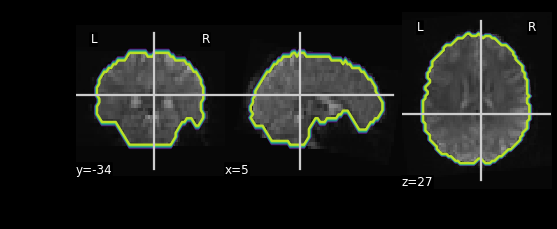

In [19]:
mean_epi_img = image.mean_img(fmri_imgs)

display = plotting.plot_anat(mean_epi_img)
display.add_contours(fmri_glm.masker_.mask_img_)

## Ergebnisse berechnen

Wie viele runs haben wir?

In [20]:
n_runs = len(fmri_img_list)
n_runs

4

Anzahl an Regressoren insgesamt

In [21]:
design_matrix = fmri_glm.design_matrices_[-1]

In [22]:
n_cols = design_matrix.shape[1]
n_cols

36

Anzahl Regressoren pro Run

In [23]:
n_conditions = int(n_cols/n_runs)
n_conditions

9

So viele Nullen wie Regressoren

In [24]:
zero_array = np.zeros(n_conditions)
zero_array

array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

Liste mit allen Bedingungen

In [25]:
cond_names = np.unique([x.split('-')[0] for x in design_matrix.columns if 'drift' not in x and 'constant' not in x])
cond_names

array(['EMOTION', 'GESICHTER', 'MOTORIK', 'RUHE', 'SPRACHE'], dtype='<U9')

In [26]:
conditions = {}
for i,cond in enumerate(cond_names):
    this_array = zero_array.copy()
    this_array[i] = 1
    conditions[cond] = np.array(list(this_array)*n_runs)

In [27]:
conditions

{'EMOTION': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0.]),
 'GESICHTER': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0.]),
 'MOTORIK': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0.]),
 'RUHE': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0.]),
 'SPRACHE': array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0.])}

In [28]:
def show_conds(conditions):
    con_df = pd.DataFrame(conditions,index=design_matrix.columns).T
    plt.figure(figsize=(24,4))
    sns.heatmap(con_df,
                square=True,cbar=False,cmap='Greys_r',annot=True);
    plt.show()

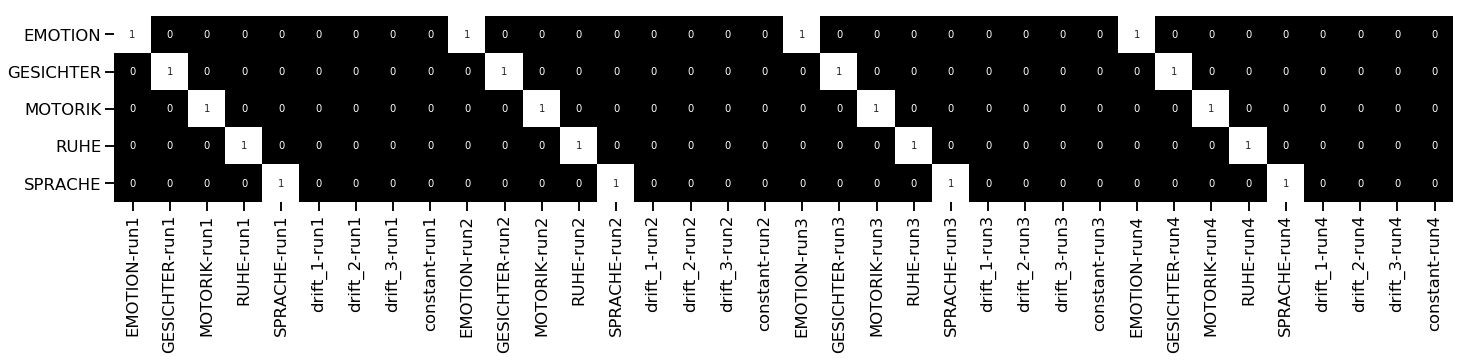

In [29]:
show_conds(conditions)

### Einen Kontrast definieren

In [30]:
def make_contrasts(c,conditions=conditions):
    
    # gewichte der gewählten bedingung
    this_condition = conditions[c]
    # alle anderend bedingungen
    other_conditions = [x for x in conditions.keys() if x!=c]

    # leerer array für die summe der gewichte der anderen bedingungen
    others = np.zeros(this_condition.shape[0])
    # für jede der anderen bedingungen
    for o in other_conditions:
        # addiere die gewichte der bedingung
        others += conditions[o]
    # teile die summe der gewichte durch die anzahl der bedingungen
    others = others/len(other_conditions)
    
    # gewählte bedingung minus mittel aller anderen
    contrast = this_condition - others
    
    return contrast

Beispiel:

In [31]:
def show_conts(contrast,design_matrix=design_matrix):
    con_df = pd.DataFrame(contrast,index=design_matrix.columns).T
    plt.figure(figsize=(18,4))
    sns.heatmap(con_df,
                square=True,cbar=False,cmap='Greys_r',annot=True);
    plt.yticks([])
    plt.show()

In [32]:
emo_gr_alles_andere = make_contrasts('EMOTION')

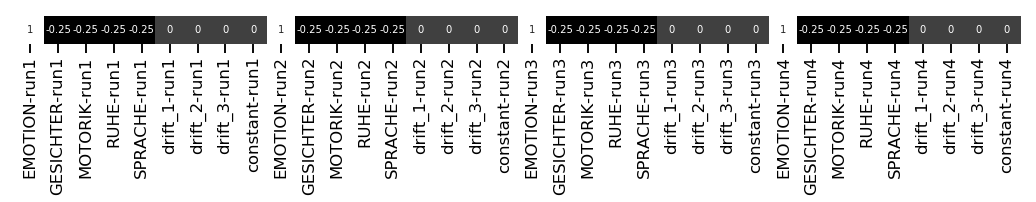

In [33]:
show_conts(emo_gr_alles_andere)

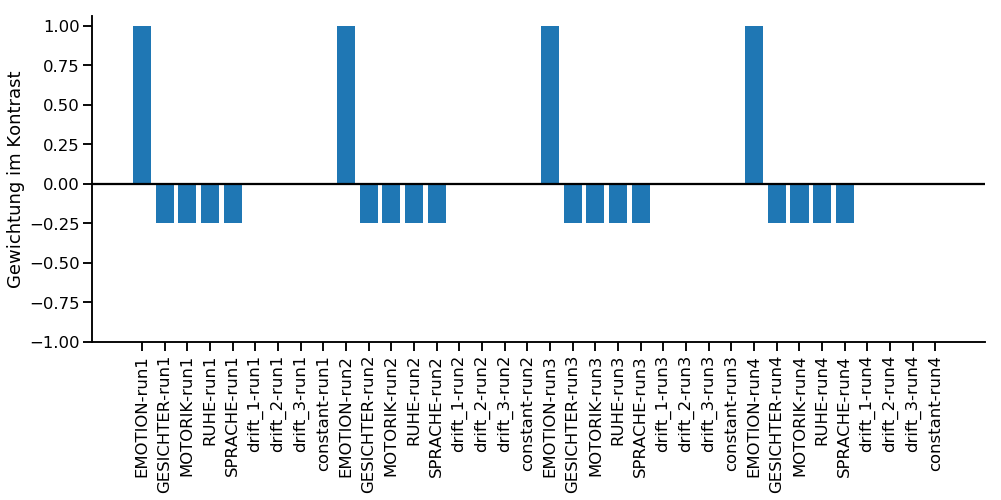

In [34]:
plt.figure(figsize=(16,6))
plt.bar(range(len(emo_gr_alles_andere)),emo_gr_alles_andere)
plt.axhline(0,color='k')
plt.yticks(np.arange(-1,1.01,0.25))
plt.ylabel('Gewichtung im Kontrast')
plt.xticks(range(len(design_matrix.columns)),design_matrix.columns,rotation=90)
sns.despine()
plt.show()

Für alle Bedingungen:

In [35]:
contrasts = {}
for c in conditions:
    contrasts[c] = make_contrasts(c)

In [36]:
contrasts

{'EMOTION': array([ 1.  , -0.25, -0.25, -0.25, -0.25,  0.  ,  0.  ,  0.  ,  0.  ,
         1.  , -0.25, -0.25, -0.25, -0.25,  0.  ,  0.  ,  0.  ,  0.  ,
         1.  , -0.25, -0.25, -0.25, -0.25,  0.  ,  0.  ,  0.  ,  0.  ,
         1.  , -0.25, -0.25, -0.25, -0.25,  0.  ,  0.  ,  0.  ,  0.  ]),
 'GESICHTER': array([-0.25,  1.  , -0.25, -0.25, -0.25,  0.  ,  0.  ,  0.  ,  0.  ,
        -0.25,  1.  , -0.25, -0.25, -0.25,  0.  ,  0.  ,  0.  ,  0.  ,
        -0.25,  1.  , -0.25, -0.25, -0.25,  0.  ,  0.  ,  0.  ,  0.  ,
        -0.25,  1.  , -0.25, -0.25, -0.25,  0.  ,  0.  ,  0.  ,  0.  ]),
 'MOTORIK': array([-0.25, -0.25,  1.  , -0.25, -0.25,  0.  ,  0.  ,  0.  ,  0.  ,
        -0.25, -0.25,  1.  , -0.25, -0.25,  0.  ,  0.  ,  0.  ,  0.  ,
        -0.25, -0.25,  1.  , -0.25, -0.25,  0.  ,  0.  ,  0.  ,  0.  ,
        -0.25, -0.25,  1.  , -0.25, -0.25,  0.  ,  0.  ,  0.  ,  0.  ]),
 'RUHE': array([-0.25, -0.25, -0.25,  1.  , -0.25,  0.  ,  0.  ,  0.  ,  0.  ,
        -0.25, -0.25, -0.25,

### Ergebniskarten generieren

In [37]:
result_maps = {}
for c in contrasts:
    contrast = contrasts[c]
    result_maps[c] = fmri_glm.compute_contrast(contrast,
                                               output_type='z_score' # art des outputs hier auswählen
                                               )

Dictionary mit Ergebniskarten

In [38]:
result_maps

{'EMOTION': <nibabel.nifti1.Nifti1Image at 0x7fdee0eb7160>,
 'GESICHTER': <nibabel.nifti1.Nifti1Image at 0x7fdee002b710>,
 'MOTORIK': <nibabel.nifti1.Nifti1Image at 0x7fdee0e257f0>,
 'RUHE': <nibabel.nifti1.Nifti1Image at 0x7fdee0eabb70>,
 'SPRACHE': <nibabel.nifti1.Nifti1Image at 0x7fdee0eabd68>}

Ergebniskarten visualisieren

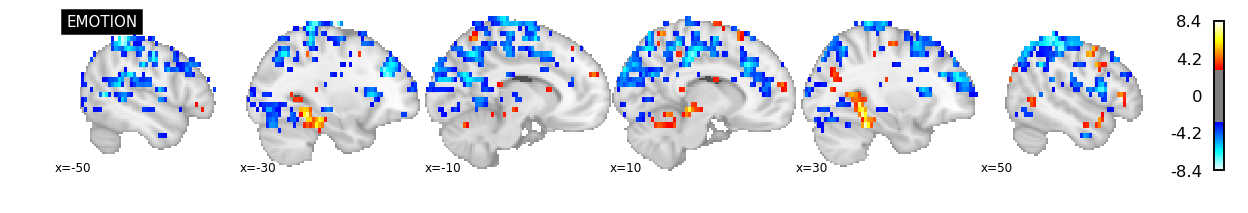

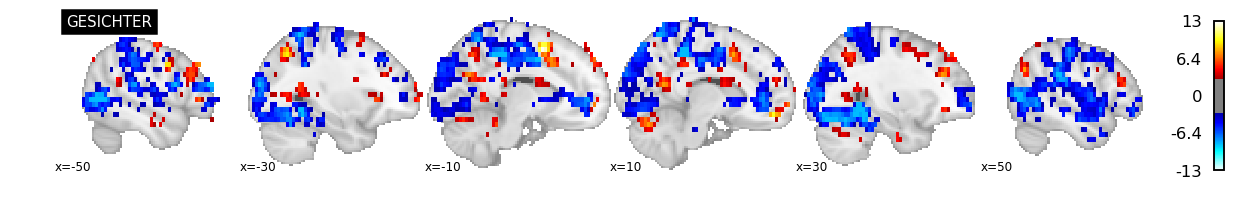

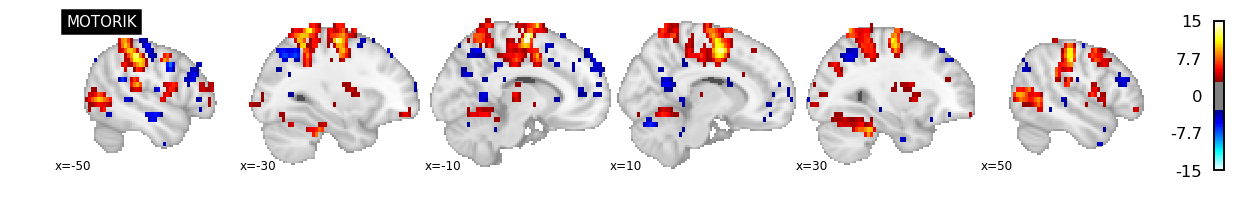

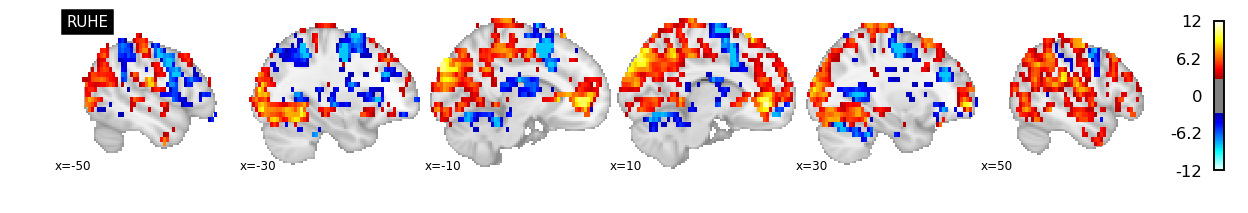

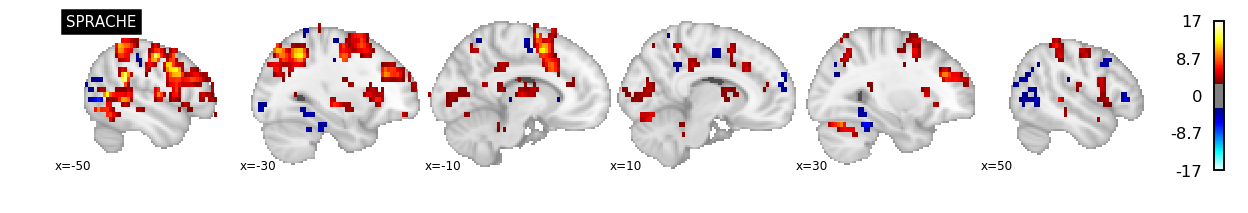

In [39]:
for c in result_maps:
    im = result_maps[c]
    plotting.plot_stat_map(im,threshold=3,display_mode='x',cut_coords=range(-50,51,20),title=c)
    plt.show()

## Daten aus anatomischen Regionen extrahieren

Einen Atlas laden

In [40]:
from nilearn import datasets

In [41]:
atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')

<font color=orange>__Modifikation:__ Atlas mit anderen Einstellungen laden</font>  
<font color=red>__Modifikation:__ Einen anderen Atlas verwenden</font>

Den Atlas anzeigen

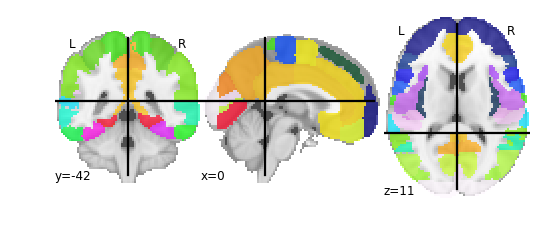

In [42]:
plotting.plot_roi(atlas['maps'])

Die Regionen die im Atlas enthalten sind auflisten

In [43]:
pd.DataFrame(atlas['labels'])

,0
0,Background
1,Frontal Pole
2,Insular Cortex
3,Superior Frontal Gyrus
4,Middle Frontal Gyrus
5,"Inferior Frontal Gyrus, pars triangularis"
6,"Inferior Frontal Gyrus, pars opercularis"
7,Precentral Gyrus
8,Temporal Pole
9,"Superior Temporal Gyrus, anterior division"


#### Den Atlas zum Extrahieren der Daten verwenden

In [44]:
atlas_masker = input_data.NiftiLabelsMasker(atlas['maps'],background_label=None).fit()

Eine Karte auswählen:

In [45]:
result_map = result_maps['SPRACHE']

In [46]:
atlas_data = atlas_masker.transform([ result_maps['SPRACHE'] ])

/opt/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


<font color=green>__Modifikation:__ Eine andere Statistikkarte als Input verwenden</font>  
<font color=orange>__Modifikation:__ Alle Statistikkarten gleichzeitig als Input verwenden</font>  

Die extrahierten Werte:

In [47]:
atlas_data

array([[ 0.06180236,  0.99629495,  1.3978982 ,  0.89621262,  1.09293516,
         0.82790355,  3.1677413 ,  1.44603343, -0.05708541,  1.24328499,
         2.49807529,  0.06486479,  0.62416273,  1.03436353, -0.09381468,
        -0.07251011,  0.87627315,  1.38798975,  0.80279807,  1.20705932,
         2.61896899,  0.02443036,  0.47941486, -0.60233236,  2.44579446,
        -0.26539796,  1.97016959,  0.        ,  0.86840246,  1.66822456,
         0.67475665, -0.20906208,  0.79169397,  0.23195524, -0.01070588,
        -0.39959268,  0.83347398, -0.21776037, -0.60081747, -0.63463623,
         0.68973897,  4.89557832,  1.74253049,  0.80806746,  0.91831182,
         1.09789406,  1.60043263,  1.44568457,  0.5172147 ]])

In [48]:
atlas_data.shape

(1, 49)

Die extrahierten Werte in eine Tabelle packen

In [49]:
atlas_data_df = pd.DataFrame(atlas_data,columns=atlas['labels']).T
atlas_data_df.columns = ['Sprache']

In [53]:
atlas_data_df

,Sprache
Background,0.061802
Frontal Pole,0.996295
Insular Cortex,1.397898
Superior Frontal Gyrus,0.896213
Middle Frontal Gyrus,1.092935
"Inferior Frontal Gyrus, pars triangularis",0.827904
"Inferior Frontal Gyrus, pars opercularis",3.167741
Precentral Gyrus,1.446033
Temporal Pole,-0.057085
"Superior Temporal Gyrus, anterior division",1.243285


<font color=green>__Modifikation:__ Die Daten in einer Abbildung visualisieren</font>

<font color=orange>__Modifikation:__ Eine Abbildung erstellen in der die Regionen nach Aktivierungstärke sortiert sind</font>

<font color=red>__Modifikation:__ Die Daten aller 5 Aktivierungskarten in einer Abbildung miteinander vergleichen</font>